# Load Libraries

In [37]:
import tensorflow

In [38]:
# dl packages

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud


# Load data

In [8]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# get all words length in comment
train_data['length'] = [len(x) for x in train_data['Comment']]

In [9]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [10]:
train_data.shape

(16000, 3)

In [11]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [12]:
train_data.duplicated().sum()

1

# EDA

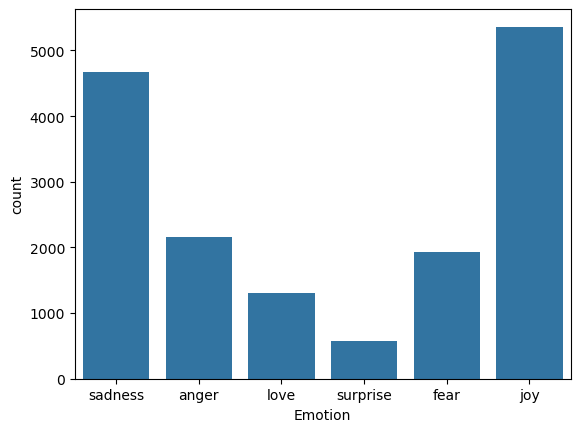

In [13]:
sns.countplot(x = train_data['Emotion'])
plt.show()

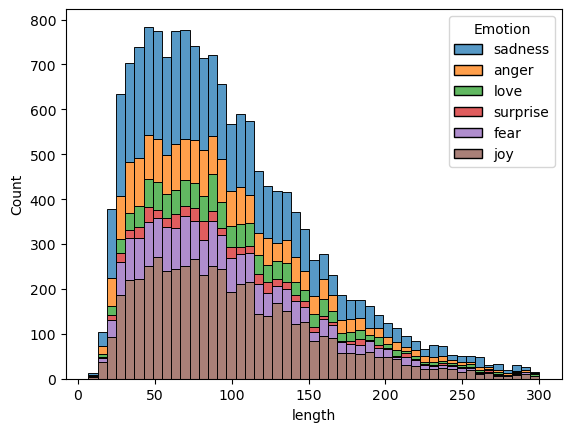

In [14]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

# Convert the 'length' column to a numpy array
length_values = df2['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show()

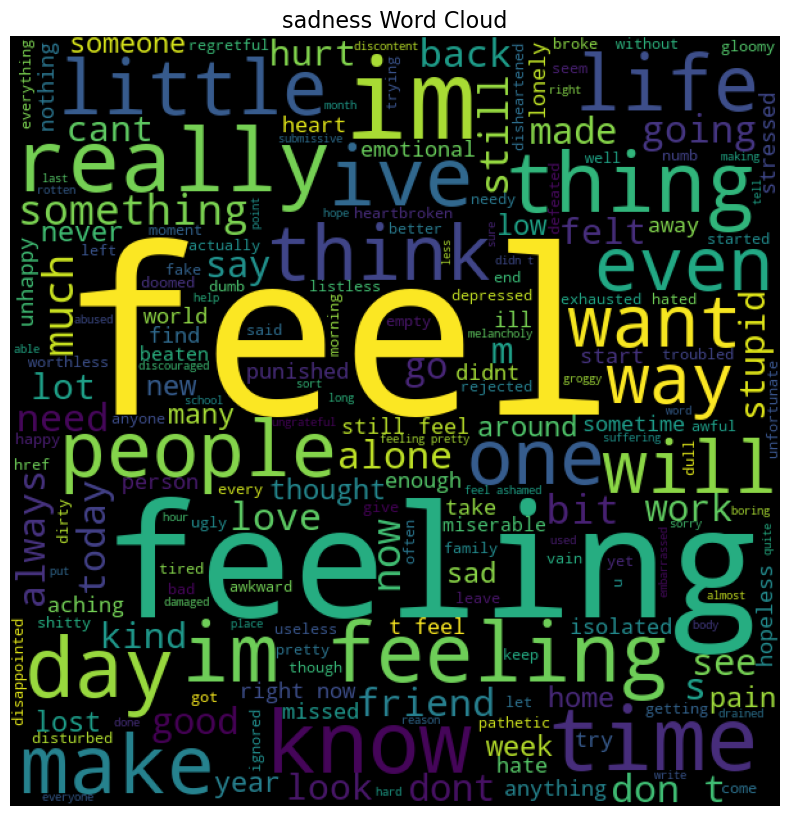

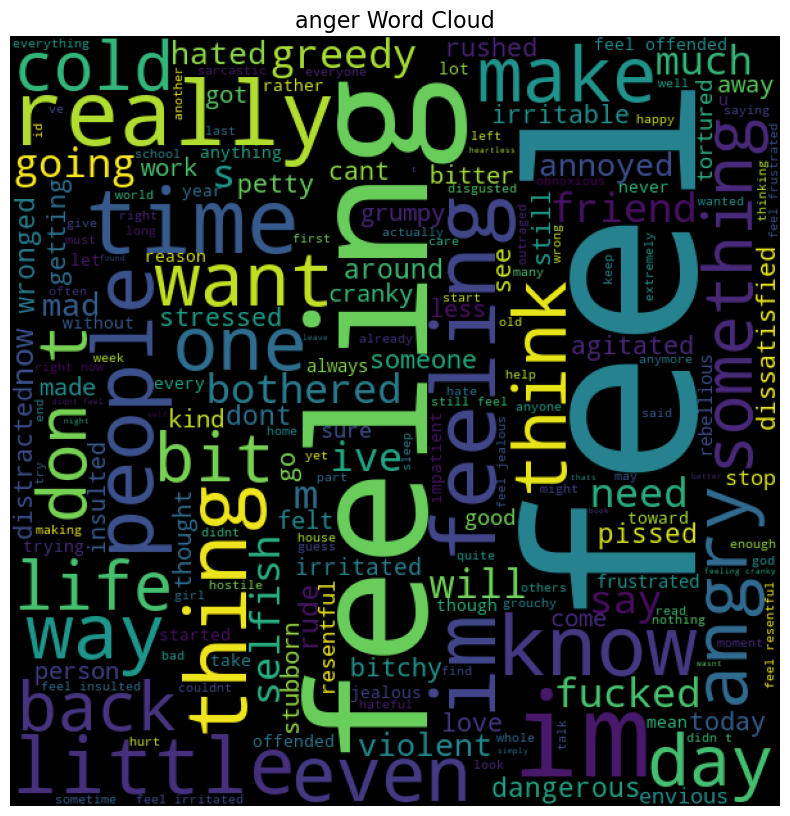

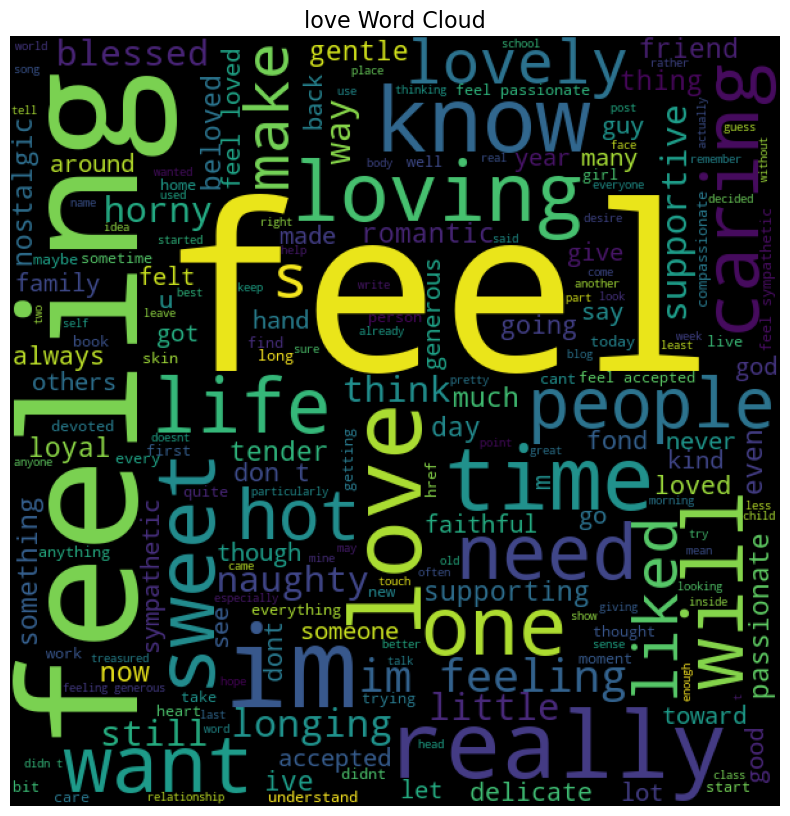

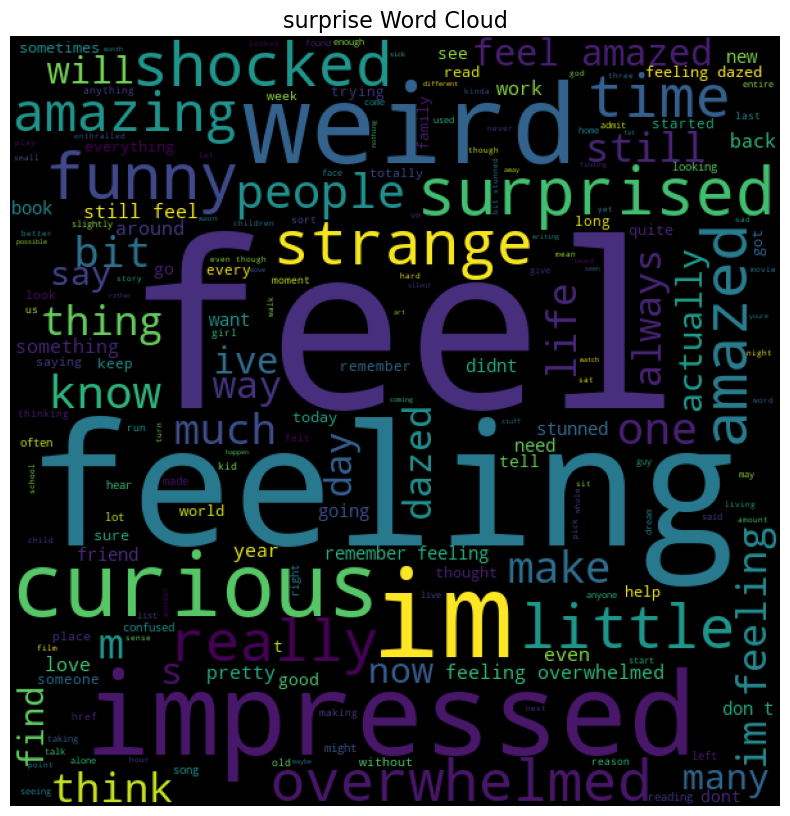

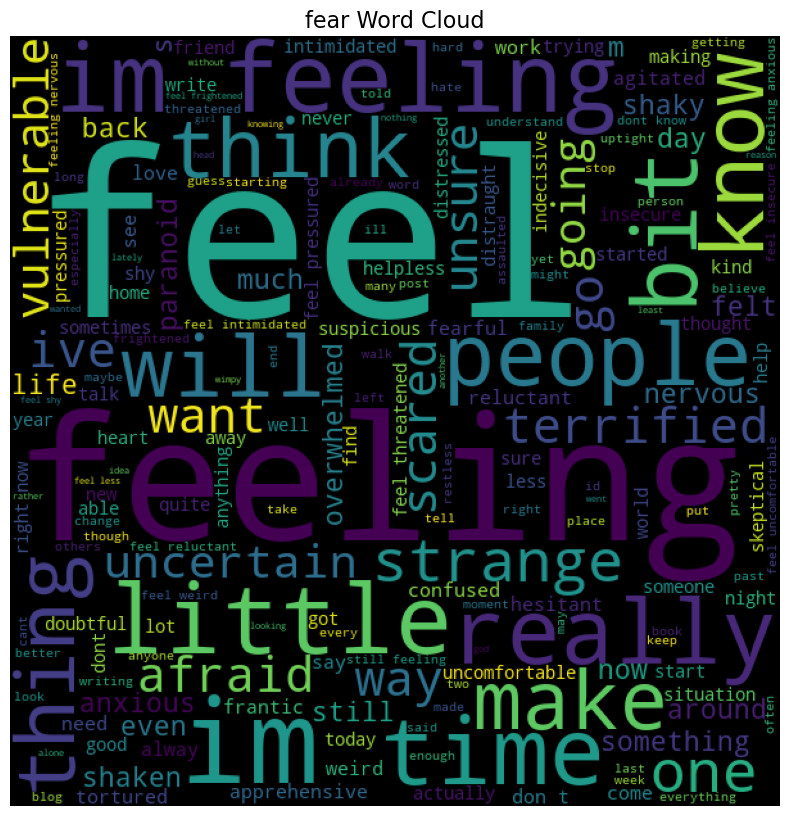

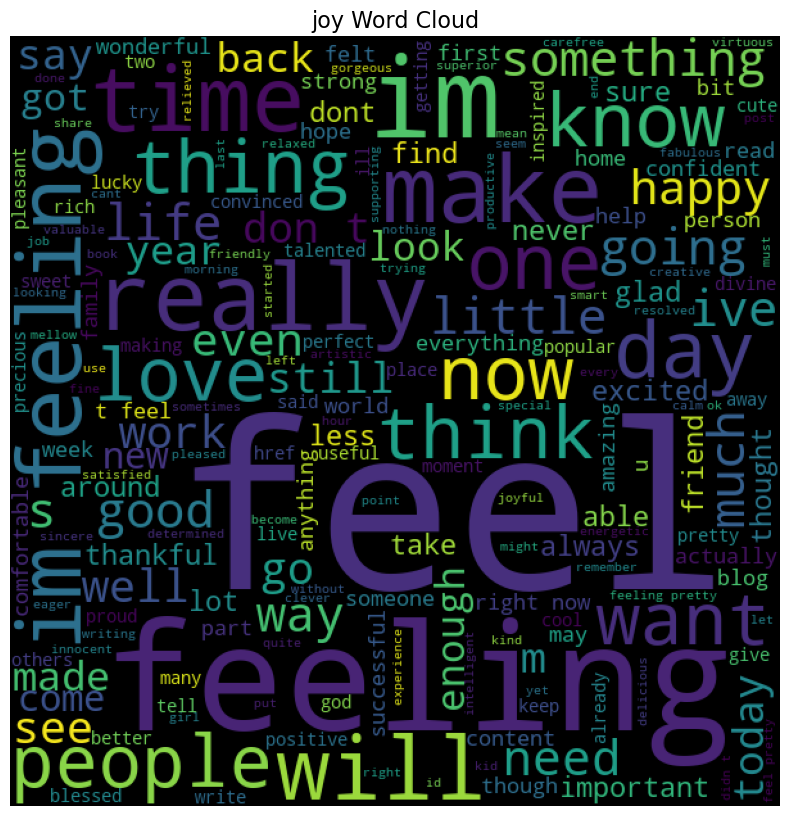

In [15]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

# Data Preprocessing
# Encode emotions

In [16]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [17]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


# Applying Machine Learning

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [19]:
df = train_data.copy() # copy df from train_data because we will use this for deep learing next

In [20]:
df

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


In [21]:
# Data cleaning and preprocessing
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text)

[nltk_data] Downloading package stopwords to C:\Users\Pranita
[nltk_data]     Kumbhar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['Emotion'],test_size=0.2,random_state=42)

In [23]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [24]:
# Multi-class classification using different algorithms
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\nAccuracy using TF-IDF: {accuracy_tfidf}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tfidf))


===== Multinomial Naive Bayes =====

Accuracy using TF-IDF: 0.655
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200


===== Logistic Regression =====

Accuracy using TF-IDF: 0.829375
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
       

In [26]:
# selecting model
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
rf_y_pred = rf.predict(X_test_tfidf)

In [35]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = rf.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label =  np.max(rf.predict(input_vectorized))

    return predicted_emotion,label

# Example usage 
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Label :",label)
    print("================================================================")

i didnt feel humiliated
Prediction : sadness
Label : 4
i feel strong and good overall
Prediction : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Label : 0
He was speechles when he found out he was accepted to this new job
Prediction : joy
Label : 2
This is outrageous, how can you talk like that?
Prediction : anger
Label : 0
I feel like im all alone in this world
Prediction : sadness
Label : 4
He is really sweet and caring
Prediction : love
Label : 3
You made me very crazy
Prediction : anger
Label : 0
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Label : 3
i am feeling grouchy
Prediction : anger
Label : 0
He hates you
Prediction : anger
Label : 0


In [36]:
# save files
import pickle
pickle.dump(rf,open("random_forest.pkl",'wb'))
pickle.dump(lb,open("label_encoder.pkl",'wb'))
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl",'wb'))

In [ ]:
import sklearn
print(sklearn.__version__)

1.5.1


# Applying Deep learning Using LSTM

# Text Cleaning, Ecoding, and Padding

In [39]:
# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

# Model Building and Training

In [40]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10


c:\Users\Pranita Kumbhar\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 242ms/step - accuracy: 0.3027 - loss: 1.7073
Epoch 2/10


c:\Users\Pranita Kumbhar\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 244ms/step - accuracy: 0.5860 - loss: 1.1793
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.7770 - loss: 0.6542
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.8665 - loss: 0.4275
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.8972 - loss: 0.3216
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.9301 - loss: 0.2302
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.9451 - loss: 0.1854
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.9494 - loss: 0.1605
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.9563 - loss: 0.1393
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.9689 - loss: 0.1047


# Predictive System

In [41]:
# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict 
sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
joy : 0.9984190464019775


im grabbing a minute to post i feel greedy wrong
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
anger : 0.9972437620162964


He was speechles when he found out he was accepted to this new job
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
joy : 0.9345287084579468


This is outrageous, how can you talk like that?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
anger : 0.9870497584342957


I feel like im all alone in this world
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
sadness : 0.9952789545059204


He is really sweet and caring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
love : 0.8329736590385437


You made me very crazy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
joy : 0.9

# Save the model and files

In [42]:

model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)